# Measuring Single Chip Performance on Tensor Processing Tasks


In [1]:
from pathlib import Path
import sys

from typing import Literal

import jax

platform : Literal["darwin", "colab", "cuda"] = "darwin"

try:
    import google.colab
    platform = "colab"
except ImportError:
    devices = jax.devices()
    if any(d.platform == "gpu" for d in devices):
        platform = "cuda"

print(f"Running on {platform}")

if platform == "colab":
    !git clone https://github.com/novastar53/high_performance_jax
    !cd high_performance_jax && git pull
    !git clone https://github.com/novastar53/deepkit
    !cd deepkit && git pull
    hpj_dir = str(Path().absolute() / "high_performance_jax" / "src" )
    dt_dir = str(Path().absolute() / "deepkit" / "src" )
    sys.path.append(hpj_dir)
    print(hpj_dir)
    sys.path.append(dt_dir)
    print(dt_dir)

Running on colab
Cloning into 'high_performance_jax'...
remote: Enumerating objects: 108, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 108 (delta 49), reused 75 (delta 34), pack-reused 0 (from 0)
Receiving objects: 100% (108/108), 584.54 KiB | 2.34 MiB/s, done.
Resolving deltas: 100% (49/49), done.
Already up to date.
Cloning into 'deepkit'...
remote: Enumerating objects: 244, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 244 (delta 0), reused 0 (delta 0), pack-reused 208 (from 1)
Receiving objects: 100% (244/244), 232.42 KiB | 1.24 MiB/s, done.
Resolving deltas: 100% (128/128), done.
Already up to date.
/content/high_performance_jax/src
/content/deepkit/src


Devices:
1. TPU v5 lite
dim 64 | average time (ms): 0.17 | hbm xfer/s 1.48e+08 | flops 5.20e+05 | intensity 21.1667 |teraflops/s 0.0031
dim 128 | average time (ms): 0.16 | hbm xfer/s 6.07e+08 | flops 4.18e+06 | intensity 42.5000 |teraflops/s 0.0258
dim 256 | average time (ms): 0.18 | hbm xfer/s 2.24e+09 | flops 3.35e+07 | intensity 85.1667 |teraflops/s 0.1911
dim 512 | average time (ms): 0.18 | hbm xfer/s 8.65e+09 | flops 2.68e+08 | intensity 170.5000 |teraflops/s 1.4743
dim 1024 | average time (ms): 0.25 | hbm xfer/s 2.53e+10 | flops 2.15e+09 | intensity 341.1667 |teraflops/s 8.6341
dim 2048 | average time (ms): 0.29 | hbm xfer/s 8.67e+10 | flops 1.72e+10 | intensity 682.5000 |teraflops/s 59.1856
dim 4096 | average time (ms): 0.92 | hbm xfer/s 1.09e+11 | flops 1.37e+11 | intensity 1,365.1667 |teraflops/s 149.0156
dim 8192 | average time (ms): 6.15 | hbm xfer/s 6.55e+10 | flops 1.10e+12 | intensity 2,730.5000 |teraflops/s 178.7308
dim 16384 | average time (ms): 46.66 | hbm xfer/s 3.45e

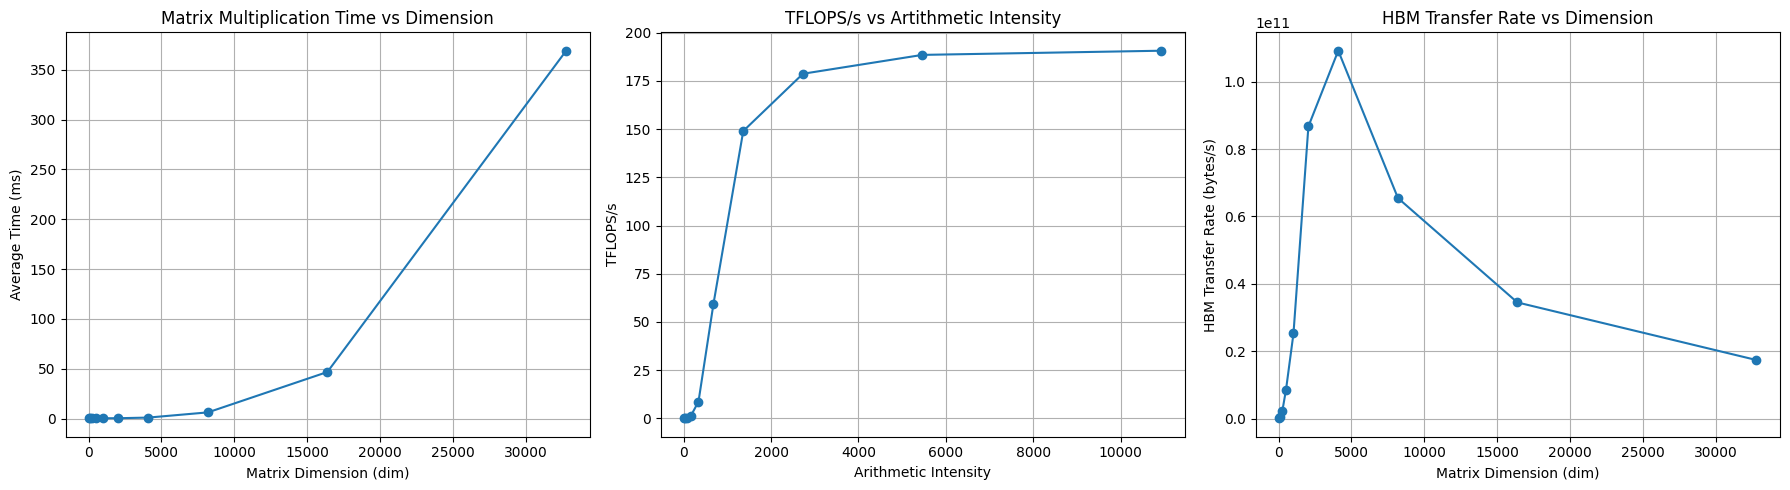

In [18]:
from deepkit.utils import timeit
from high_performance_jax.single_chip_performance import *
import matplotlib.pyplot as plt

dtype = jnp.bfloat16
devices = jax.devices()
print("Devices:")
for i,d in enumerate(devices):
  print(f"{i+1}. {d.device_kind}")    # e.g. “TPU v3”


#####################################
##        jax.lax matmul presets   ##
#####################################
## 'ANY_F8_ANY_F8_F32',
## 'ANY_F8_ANY_F8_F32_FAST_ACCUM'
## 'ANY_F8_ANY_F8_ANY'
## 'ANY_F8_ANY_F8_ANY_FAST_ACCUM'
## 'F16_F16_F16'
## 'F16_F16_F32'
## 'BF16_BF16_BF16'
## 'BF16_BF16_F32'
## 'BF16_BF16_F32_X3'
## 'BF16_BF16_F32_X6'
## 'TF32_TF32_F32'
## 'TF32_TF32_F32_X3'
## 'F32_F32_F32'
## 'F64_F64_F64'
#####################################
jax.config.update("jax_default_matmul_precision", "BF16_BF16_F32") # Set the default precision for matrix multiplication

dims = [2**i for i in range(6, 16)]
times = []
tflops = []
hbm_rates = []
intensities = []

for dim in dims:
    A = jnp.ones((dim, dim), dtype=dtype)
    B = jnp.ones((dim, dim), dtype=dtype)
    #C = jnp.ones((dim, dim), dtype=dtype)
    task = "matmul"

    average_time_ms = timeit(jax.jit(matmul), A, B)
    flops = measure_tpu_flops(task, dim)
    times.append(average_time_ms)
    tflops.append(1000 * flops / average_time_ms / 10**12)
    hbm_xfer = measure_tpu_hbm_memory_transfer(task, dim, dtype)
    hbm_rates.append(1000 * hbm_xfer / average_time_ms)
    arithmetic_intensity = flops / hbm_xfer
    intensities.append(arithmetic_intensity)

    print(f"dim {dim} | average time (ms): {average_time_ms:.2f} | "
            f"hbm xfer/s {hbm_rates[-1]:.2e} | "
            f"flops {flops:.2e} | "
            f"intensity {arithmetic_intensity:,.4f} |"
            f"teraflops/s {tflops[-1]:,.4f}")

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

ax1.plot(dims, times, marker='o')
#ax1.set_xscale('log')
ax1.set_xlabel("Matrix Dimension (dim)")
ax1.set_ylabel("Average Time (ms)")
ax1.set_title("Matrix Multiplication Time vs Dimension")
ax1.grid(True)

ax2.plot(intensities, tflops, marker='o')
#ax1.set_xscale('log')
ax2.set_xlabel("Arithmetic Intensity")
ax2.set_ylabel("TFLOPS/s")
ax2.set_title("TFLOPS/s vs Artithmetic Intensity")
ax2.grid(True)

ax3.plot(dims, hbm_rates, marker='o')
#ax3.set_xscale('log')
ax3.set_xlabel("Matrix Dimension (dim)")
ax3.set_ylabel("HBM Transfer Rate (bytes/s)")
ax3.set_title("HBM Transfer Rate vs Dimension")
ax3.grid(True)

plt.tight_layout()
plt.show()